## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
from scipy import stats
%matplotlib inline

In [107]:
import warnings
warnings.filterwarnings("ignore")

## Global Variables

In [2]:
data_folder_name = 'Data'
raw_data_folder_name = 'Raw_Data'
train_csv_name = 'train.csv'
test_csv_name = 'test.csv'

## File paths

In [3]:
project_path = os.path.abspath(os.path.join(os.getcwd(),os.pardir))
data_folder = os.path.join(project_path,data_folder_name)
raw_data_path = os.path.join(data_folder,raw_data_folder_name)
train_data_path = os.path.join(raw_data_path,train_csv_name)
test_data_path = os.path.join(raw_data_path,test_csv_name)

## Helper Functions

In [394]:
#------------------------------------Describing---------------------------
def describe_IQR(df):
    desc_df = pd.DataFrame(df.describe())
    iqr_series = desc_df.loc['75%'] - desc_df.loc['25%']
    frame = {'IQR': iqr_series}
    desc_df = desc_df.append(pd.DataFrame(frame).T)
    
    min_thresh = desc_df.loc['25%'] - 1.5*desc_df.loc['IQR']
    max_thresh = desc_df.loc['75%'] + 1.5*desc_df.loc['IQR']

    frame = {'min_IQR_thresh':min_thresh, 'max_IQR_thresh':max_thresh}
    desc_df = desc_df.append(pd.DataFrame(frame).T)

    return desc_df
#---------------------------------------------------------------
def unique_identifiers(train_data):
    dic = dict()

    for column in train_data.columns:
        column_uniqueness = train_data[column].nunique()
        dic[column] =column_uniqueness

    uniques_df = pd.DataFrame(pd.Series(dic).sort_values(ascending=False), columns={'#unique'})
    uniques_df['%unique'] = round((uniques_df['#unique']/m)*100,2)
    uniques_df['unique_identifier_flag'] = uniques_df['%unique'].apply(lambda x:'Y' if x==100.00 else 'N')
    return uniques_df
#---------------------------------------------------------------
def numeric_desc(df):  #what is density?
    df = df.select_dtypes(include=[np.number])
    unique_identifier_cols = df.columns[df.columns.isin(unique_identifiers)]
    NoNunique_identifier_cols = df.columns[~df.columns.isin(unique_identifiers)]
    desc = pd.DataFrame()
    desc['Type'] = df.dtypes
    desc['Density'] = np.nan
    desc['No. of Values'] = df.count()
    desc['No. of Unique Values'] = df.nunique(dropna=False) # taking nans into consideration
    desc['No. of NaN'] = df.apply(np.isnan, axis=1).sum()
    desc['No. of Zeros'] = len(df)- np.count_nonzero(df, axis=0)
    desc['No. of +ve Values'] = df.apply(lambda x: x>0).sum()
    desc['Min'] = df.min()
    desc['Max'] = df.max()
    desc['Mean'] = df.mean()
    desc['Std'] = df.std()
    desc['Median'] = df.median(skipna=False) # taking nans into consideration
    desc['Mode'] = df[NoNunique_identifier_cols].mode().T #remove the columns that have 100% uniqueness
    desc['Skew'] = df.skew()
    desc['Kurtosis'] = df.kurtosis() #-ve >> left tailed dist // +ve >> right tailed //0 >>normal dist
    desc['No. of 3 Sigma Outliers'] = (np.abs(stats.zscore(df,nan_policy='omit')) > 3).sum(axis=0) #omitting nans to match describe2
    return desc
#---------------------------------------------------------------
def object_desc(df):  #what is density?
    df = df.select_dtypes(include=[np.object])
    desc = pd.DataFrame(index=df.columns)
    desc['Type'] = df.dtypes
    desc['Density'] = np.nan
    desc['No. of Values'] = df.count() #non na values
    desc['No. of Unique Values'] = df.nunique(dropna=False) # taking nans into consideration
    desc['No. of NaN'] = df.isnull().sum()
    return desc

def desc(df):
    nums =  numeric_desc(df)
    obj =   object_desc(df)
    return nums,obj  
#---------------------------------------------------------------
#------------------------------------Plotting---------------------------
#---------------------------------------------------------------
def colors_list(unique_list):
    length = len(unique_list)
    colors_list = ['orange']
    colors_list.extend(['blue']*(length-1))
    return colors_list

#---------------------------------------------------------------

def colors_list_sorted(train_data_copy,var_name,var_unique_list):
    train_data_copy = train_data_copy.set_index(var_name)
    means_index_sorted = pd.DataFrame(train_data_copy.groupby(level=0)['Survived'].mean()).sort_values(by='Survived',ascending=False)
    colors_listed = colors_list(var_unique_list)
    colors_df = pd.DataFrame(index = means_index_sorted.index, data= {'colors': colors_listed})
    colors_df = colors_df.sort_index()
    return list(colors_df.sort_index()['colors'])

#---------------------------------------------------------------

def variable_mean_survival(var_name):
    train_data_copy = train_data[~train_data[var_name].isna()]
    train_data_copy['Survived'] =  train_data_copy['Survived'].astype(int)
    if train_data_copy[var_name].dtype.name != 'category':
        var_unique_list = sorted(list(train_data_copy[var_name].unique())) 
    else:
        var_unique_list = list(train_data[var_name].dtype.categories)
    countPerVarValue = pd.DataFrame(train_data_copy.groupby(var_name)['PassengerId'].count(),index = var_unique_list)['PassengerId'] 
    avg_survival = pd.DataFrame(train_data_copy.set_index(var_name).groupby(level=0)['Survived'].mean(),index = var_unique_list)['Survived']

    colors_map = colors_list_sorted(train_data_copy,var_name,var_unique_list)
                                      
    return var_unique_list, countPerVarValue, avg_survival, colors_map

def variable_mean_survival_subset(df,var_name):
    train_data_copy = df[~train_data[var_name].isna()]
    train_data_copy['Survived'] =  train_data_copy['Survived'].astype(int)
    var_unique_list = sorted(list(train_data_copy[var_name].unique()))     
    countPerVarValue = pd.DataFrame(train_data_copy.groupby(var_name)['PassengerId'].count(),index = var_unique_list)['PassengerId'] 
    avg_survival = pd.DataFrame(train_data_copy.set_index(var_name).groupby(level=0)['Survived'].mean(),index = var_unique_list)['Survived']

    colors_map = colors_list_sorted(train_data_copy,var_name,var_unique_list)
                                      
    return var_unique_list, countPerVarValue, avg_survival, colors_map

#---------------------------------------------------------------

def plt_settings(cur_plt, ititle):
    ax = cur_plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    #ax.get_yaxis().set_visible(False)  
    ax.set_yticklabels([])
    plt.title(ititle)
    for i, rect in enumerate(ax.patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height,  str(round(height, 2)),
                ha='center', va='bottom')  
#---------------------------------------------------------------

def plt_simple_settings(cur_plt, ititle):
    ax = cur_plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    #ax.get_yaxis().set_visible(False)  
    #ax.set_yticklabels([])
    plt.title(ititle)
    #for i, rect in enumerate(ax.patches):
     #   height = rect.get_height()
     #   ax.text(rect.get_x() + rect.get_width() / 2, height,  str(round(height, 2)),
     #           ha='center', va='bottom')        

#---------------------------------------------------------------

def remove_top_right_spines(cur_plt):
    ax = cur_plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#---------------------------------------------------------------

def setup_legends(colors_dict, plt):
    labels = list(colors_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors_dict[label]) for label in labels]
    plt.subplot(1, 3, 2)
    plt_settings(plt,'')
    plt.gca().get_xaxis().set_visible(False)  
    plt.legend(handles, labels);   
    
    
    

## Loading the data

In [5]:
raw_data_train = pd.read_csv(train_data_path)

train_data = raw_data_train.copy()

# Exploring Source Variables

### full row duplicates

In [6]:
cnt_full_row_dup = sum(train_data.duplicated())
print("The data has ",cnt_full_row_dup, 'Full Row Duplications')

The data has  0 Full Row Duplications


### shape of data

In [7]:
shape = train_data.shape 
m = shape[0]
n = shape[1] - 1 #n-1 because one of the columns is the desired label
df_shape_ratio = m/n
print("The data has ", m, ' records and ', n, ' columns')

The data has  891  records and  11  columns


### nulls in data

In [8]:
nulls_df = pd.DataFrame((train_data.isnull().sum()).sort_values(ascending=False), columns={'#nulls'})
nulls_df['%nulls'] = (nulls_df['#nulls']/m*100)
nulls_df

,#nulls,%nulls
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


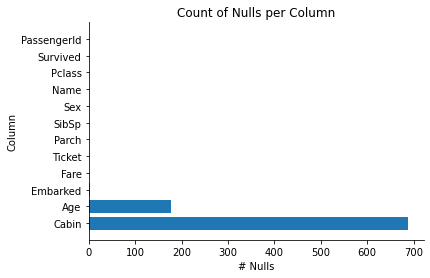

In [9]:
plt.figure()
plt.barh(nulls_df.index, width=nulls_df['#nulls'])
remove_top_right_spines(plt)
plt.title('Count of Nulls per Column');
plt.ylabel('Column')
plt.xlabel('# Nulls');

### uniqueness of data

In [16]:
uniques_df = unique_identifiers(train_data)
uniques_df

,#unique,%unique,unique_identifier_flag
Name,891,100.00,Y
PassengerId,891,100.00,Y
Ticket,681,76.43,N
Fare,248,27.83,N
Cabin,147,16.50,N
Age,88,9.88,N
Parch,7,0.79,N
SibSp,7,0.79,N
Embarked,3,0.34,N
Pclass,3,0.34,N


In [17]:
unique_identifiers= list(uniques_df[uniques_df['unique_identifier_flag']=='Y'].index)
print('The columns that can be used to uniquely identify records are: {} , {} '.format(unique_identifiers[0],unique_identifiers[1]))

The columns that can be used to uniquely identify records are: Name , PassengerId 


## Label Identification

In [291]:
lable = ['Survived']

non_lable = train_data.columns[~train_data.columns.isin(lable)]

## Fix columns data types
some columns are numerical when they should be str or categorical

In [25]:
train_data['Pclass'] = train_data['Pclass'].astype('str')
train_data['Survived'] = train_data['Survived'].astype('str')

## Describe

In [63]:
desc_df = describe_IQR(train_data)
desc_df

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200
IQR,445.000000,17.875000,1.000000,0.000000,23.089600
min_IQR_thresh,-444.000000,-6.687500,-1.500000,0.000000,-26.724000


In [297]:
numeric_desc_df = desc(train_data)[0]  
numeric_desc_df

,Type,Density,No. of Values,No. of Unique Values,No. of NaN,No. of Zeros,No. of +ve Values,Min,Max,Mean,Std,Median,Mode,Skew,Kurtosis,No. of 3 Sigma Outliers
PassengerId,int64,NaN,891,891,0,0,891,1.00,891.0000,446.000000,257.353842,446.0000,NaN,0.000000,-1.200000,0
Age,float64,NaN,714,89,177,0,714,0.42,80.0000,29.699118,14.526497,NaN,24.00,0.389108,0.178274,2
SibSp,int64,NaN,891,7,0,608,283,0.00,8.0000,0.523008,1.102743,0.0000,0.00,3.695352,17.880420,30
Parch,int64,NaN,891,7,0,678,213,0.00,6.0000,0.381594,0.806057,0.0000,0.00,2.749117,9.778125,15
Fare,float64,NaN,891,248,0,15,876,0.00,512.3292,32.204208,49.693429,14.4542,8.05,4.787317,33.398141,20


In [292]:
cat_desc_df = desc(train_data)[1]  
cat_desc_df

,Type,Density,No. of Values,No. of Unique Values,No. of NaN
Survived,object,NaN,891,2,0
Pclass,object,NaN,891,3,0
Name,object,NaN,891,891,0
Sex,object,NaN,891,2,0
Ticket,object,NaN,891,681,0
Cabin,object,NaN,204,148,687
Embarked,object,NaN,889,4,2


## IQR Outliers

In [90]:
IQR_outliers_df = pd.DataFrame((train_data<desc_df.loc['min_IQR_thresh']).sum() + (train_data>desc_df.loc['max_IQR_thresh']).sum(), columns={'#Outliers'} )
IQR_outliers_df['%Outliers'] = round((outliers_df['#Outliers']/m*100),2)
IQR_outliers_df

,#Outliers,%Outliers
Age,11,1.23
Cabin,0,0.00
Embarked,0,0.00
Fare,116,13.02
Name,0,0.00
Parch,213,23.91
PassengerId,0,0.00
Pclass,0,0.00
Sex,0,0.00
SibSp,46,5.16


# Data Variables Vs Survival

## What is the relation between Gender and Survival?

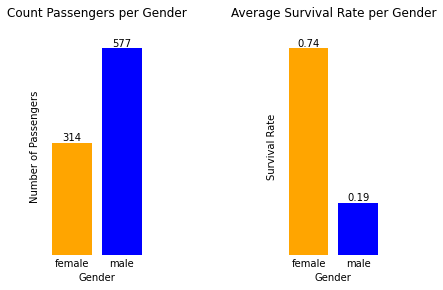

In [229]:
unique_sexes,sex_value_count, avg_survival,colors_map = variable_mean_survival('Sex')
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.bar(unique_sexes,sex_value_count,color=colors_map)
plt_settings(plt,'Count Passengers per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_sexes,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Survival Rate');

## What is the relation between Embaked and Survival? 

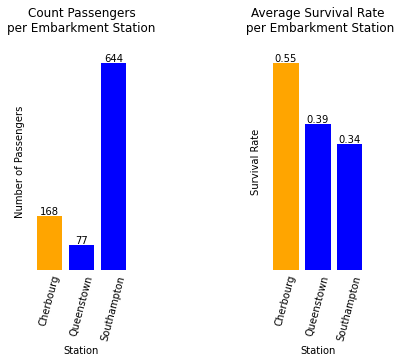

In [230]:
unique_embark,embark_value_count, avg_survival,colors_map = variable_mean_survival('Embarked')
#unique_embark = ['Cherbourg','Queenstown', 'Southampton']
plt.subplot(1, 3, 1)
plt.bar(unique_embark,embark_value_count,color=colors_map)
plt_settings(plt,'Count Passengers\nper Embarkment Station\n')
plt.xticks(ticks=['C','Q','S'],labels= ['Cherbourg','Queenstown', 'Southampton'], rotation = 75);
plt.xlabel('Station')
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_embark,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\n per Embarkment Station\n')
plt.xticks(ticks=['C','Q','S'],labels= ['Cherbourg','Queenstown', 'Southampton'], rotation = 75);
plt.xlabel('Station')
plt.ylabel('Survival Rate');

### What is the nature of passengers who embarked from Cherbourg? (Pclass & Gender)

Passengers from Cherbourg were predominantly First Class
 which explains why they have higher survival chances as we will see Later


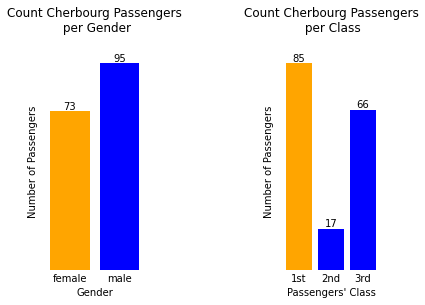

In [188]:
c_df = train_data[train_data['Embarked'] == 'C'][['PassengerId','Sex', 'Pclass', 'Survived']]
unique_sex,sex_value_count, avg_survival,colors_map = variable_mean_survival_subset(c_df,'Sex')

plt.subplot(1, 3, 1)
plt.bar(unique_sex,sex_value_count,color=colors_map)
plt_settings(plt,'Count Cherbourg Passengers\n per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers');

unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(c_df,'Pclass')
plt.subplot(1, 3, 3)
plt.bar(unique_class,class_value_count,color=colors_map)
plt_settings(plt,'Count Cherbourg Passengers\n per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Number of Passengers');

print('\033[1m'+'Passengers from Cherbourg were predominantly First Class\n which explains why they have higher survival chances as we will see Later'+'\033[1m')

## What is the relation between Passenger's Class and Survival?

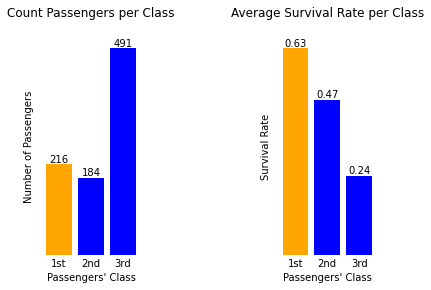

In [187]:
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival('Pclass')

plt.subplot(1, 3, 1)
plt.bar(unique_class,class_value_count,color=colors_map)
plt_settings(plt,'Count Passengers per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_class,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Survival Rate');

## What is the relation between the Passenger's travel company and Survival?
We will analyse siblings, spouses, children, and parents travelling with the passenger

### Family Vs Survival
Combine SibSp and Parch in one column indicating whether or not the passenger was travelling alone

In [167]:
def family_flag(x):
    if  (x['SibSp'] + x['Parch'])  > 0:
        return 1
    else:
        return 0

In [168]:
train_data['Family_flag']  = train_data.apply(family_flag, axis=1)

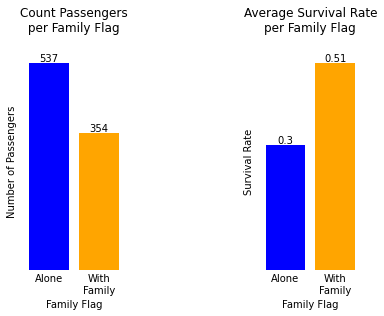

In [195]:
unique_famFlag,famFlag_value_count, avg_survival,colors_map = variable_mean_survival('Family_flag')

plt.subplot(1,3,1) 
plt.bar(list(map(str,unique_famFlag)), famFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\n per Family Flag \n')
plt.xticks(ticks=[0,1],labels=['Alone','With\nFamily']);
plt.xlabel("Family Flag")
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(list(map(str,unique_famFlag)),avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper Family Flag\n')
plt.xticks(ticks=[0,1],labels=['Alone','With\nFamily']);
plt.xlabel("Family Flag")
plt.ylabel('Survival Rate');

In [172]:
def family_flag2(x):
    sum_all =  x['SibSp'] + x['Parch']
    if sum_all == 0 :
        return 0
    elif sum_all < 4:
        return 1
    else:
        return 2

In [174]:
train_data['Family_flag2']  = train_data.apply(family_flag2, axis=1)

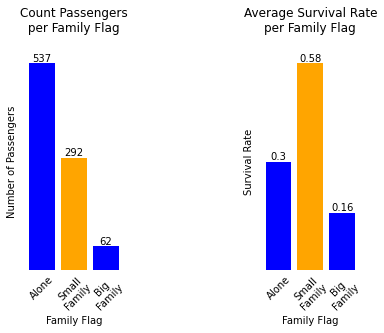

In [194]:
unique_famFlag,famFlag_value_count, avg_survival,colors_map = variable_mean_survival('Family_flag2')

plt.subplot(1,3,1) 
plt.bar(list(map(str,unique_famFlag)), famFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\n per Family Flag \n')
plt.xticks(ticks=[0,1,2],labels=['Alone','Small\nFamily', 'Big\nFamily'],  rotation = 45);
plt.xlabel("Family Flag")
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(list(map(str,unique_famFlag)),avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper Family Flag\n')
plt.xticks(ticks=[0,1,2],labels=['Alone','Small\nFamily', 'Big\nFamily'],  rotation = 45);
plt.xlabel("Family Flag")
plt.ylabel('Survival Rate');

## What is the relation between Passengers' Age and Survival?

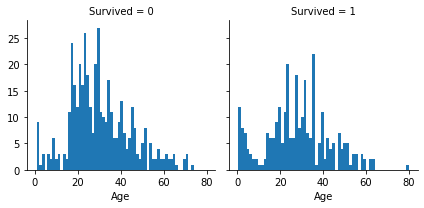

In [21]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=60)

### What is the relation between age group and survival?

In [239]:
#sort the ages into age groups #explore more about binning!
bins = [0, 2, 12, 17, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'adult', 'elderly']
age_groups = pd.cut(train_data.Age, bins, labels = labels)
train_data['Age_Group'] = age_groups

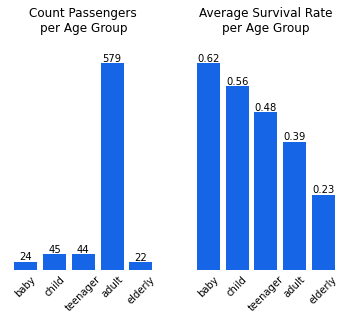

In [392]:
unique_ageGroup,ageGroup_value_count, avg_survival,colors_map = variable_mean_survival('Age_Group')

plt.subplot(1,2,1) 
plt.bar(unique_ageGroup, ageGroup_value_count, color='#1565e6') #'#0948ad'
plt_settings(plt,'Count Passengers\nper Age Group\n')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(unique_ageGroup,avg_survival,color='#1565e6')
plt_settings(plt,'Average Survival Rate\nper Age Group\n')
plt.xticks(rotation=45);

### What are the chances of survival of children with parents vs without parents?

No babies were travelling alone without parents


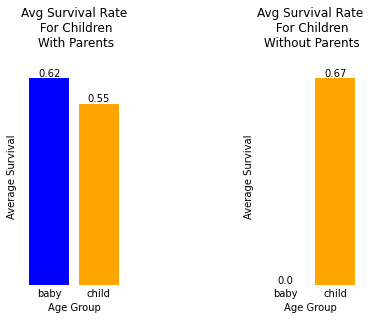

In [347]:
df = train_data[train_data['Age_Group'].isin(['baby','child'])]
unique_vals = df['Age_Group'].unique()

df['Survived'] = df['Survived'].astype(int)
df_zeroParents = df[df['Parch']==0]
df_withParents = df[df['Parch']>0]

zeroParents_avg_survival = pd.DataFrame(df_zeroParents.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']
zeroParents_avg_survival = zeroParents_avg_survival.apply(lambda x: 0 if pd.isnull(x) else x)

withParents_avg_survival = pd.DataFrame(df_withParents.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

plt.subplot(1,3,1) 
plt.bar(unique_vals, withParents_avg_survival, color=['blue','orange'])
plt_settings(plt,'Avg Survival Rate\n For Children\n With Parents\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival')

plt.subplot(1,3,3) 
plt.bar(unique_vals, zeroParents_avg_survival, color=['blue','orange'])
plt_settings(plt,'Avg Survival Rate\n For Children\n Without Parents\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival');

print('\033[1m'+'No babies were travelling alone without parents'+'\033[1m')

### What are the chances of survival of adults with childen vs without childen?

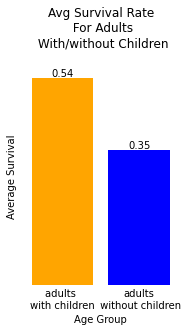

In [348]:
df = train_data[train_data['Age_Group'].isin(['adult'])]
unique_vals = df['Age_Group'].unique()

df['Survived'] = df['Survived'].astype(int)
df_zeroCh = df[df['Parch']==0]
df_withCh = df[df['Parch']>0]

zeroCh_avg_survival = pd.DataFrame(df_zeroCh.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

withCh_avg_survival = pd.DataFrame(df_withCh.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

labels = ['adults \nwith children','adults\n without children']
avg_surv = [withCh_avg_survival.values[0],zeroCh_avg_survival.values[0]]
plt.subplot(1,2,1) 
plt.bar(labels, avg_surv, color=['orange','blue'])
plt_settings(plt,'Avg Survival Rate\n For Adults\n With/without Children\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival');


### What is the relationship between Age and Class?

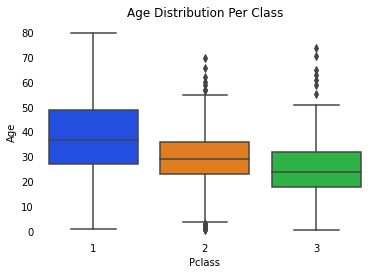

In [422]:
baby = train_data[train_data['Age_Group']=='baby']
child = train_data[train_data['Age_Group']=='child']
teenager = train_data[train_data['Age_Group']=='teenager']
adults = train_data[train_data['Age_Group']=='adult']
elderly = train_data[train_data['Age_Group']=='elderly']

sns.boxplot(x='Pclass',y='Age',data=train_data.sort_values(by='Pclass'), palette='bright')

plt_simple_settings(plt,'Age Distribution Per Class')
plt.yticks();

## Cabin Vs Survival

Following the idea that passengers of no cabin stated are of lower classes

In [423]:
train_data['Cabin_Flag'] = train_data["Cabin"].notnull().astype('int')

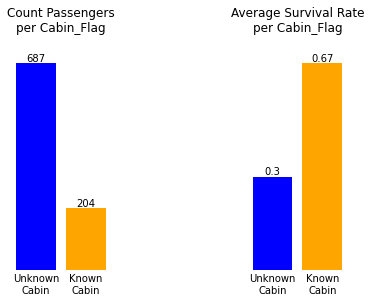

In [424]:
unique_cabinFlag,cabinFlag_value_count, avg_survival,colors_map = variable_mean_survival('Cabin_Flag')

plt.subplot(1,3,1) 
plt.bar(unique_cabinFlag, cabinFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\nper Cabin_Flag\n')
plt.xticks(ticks=[0,1],labels=['Unknown\nCabin','Known\nCabin'])

plt.subplot(1, 3, 3)
plt.bar(unique_cabinFlag,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper Cabin_Flag\n')
plt.xticks(ticks=[0,1],labels=['Unknown\nCabin','Known\nCabin']);
 

### What are the characteristics of passengers with known Vs unkown Cabins?

### Passenger Class

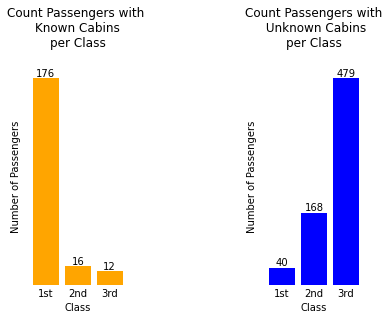

In [510]:
train_data['Survived'] = train_data['Survived'].astype(int)
unique_vals = train_data['Cabin_Flag'].unique()

known_cabins_df = train_data[train_data['Cabin_Flag']==1]
unknown_cabins_df = train_data[train_data['Cabin_Flag']==0]

plt.subplot(1,3,1)
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(known_cabins_df,'Pclass')
plt.bar(unique_class, class_value_count, color='orange')
plt_settings(plt,'Count Passengers with \nKnown Cabins\nper Class\n')
plt.xticks(ticks=[0,1,2], labels=['1st','2nd','3rd']);
plt.xlabel('Class')
plt.ylabel('Number of Passengers')


plt.subplot(1,3,3)
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(unknown_cabins_df,'Pclass')
plt.bar(unique_class, class_value_count, color='blue')
plt_settings(plt,'Count Passengers with\n Unknown Cabins\nper Class\n')
plt.xticks(ticks=[0,1,2], labels=['1st','2nd','3rd']);
plt.xlabel('Class')
plt.ylabel('Number of Passengers');

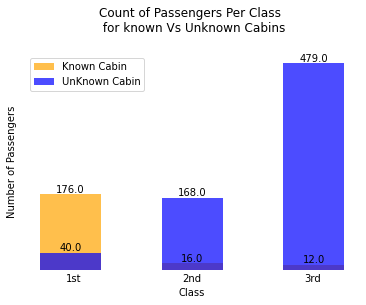

In [546]:
plt.hist(known_cabins_df['Pclass'].sort_values(), alpha=0.7, color ='orange',label='Known Cabin',bins=3,rwidth=0.5);
plt.hist(unknown_cabins_df['Pclass'].sort_values(), alpha=0.7,color ='blue', label='UnKnown Cabin',bins=3,rwidth=0.5);
plt.legend();
plt.xticks(ticks=[0.35,1,1.66], labels=['1st','2nd','3rd']);

plt_settings(plt, 'Count of Passengers Per Class \n for known Vs Unknown Cabins\n')
plt.xlabel('Class')
plt.ylabel('Number of Passengers');

### Gender

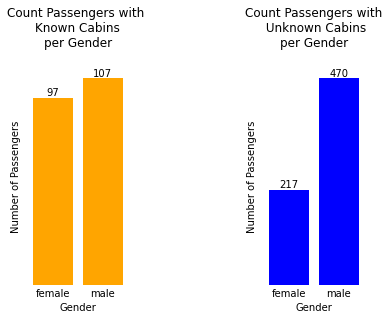

In [512]:
train_data['Survived'] = train_data['Survived'].astype(int)
unique_vals = train_data['Cabin_Flag'].unique()

known_cabins_df = train_data[train_data['Cabin_Flag']==1]
unknown_cabins_df = train_data[train_data['Cabin_Flag']==0]

plt.subplot(1,3,1)
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(known_cabins_df,'Sex')
plt.bar(unique_class, class_value_count, color='orange')
plt_settings(plt,'Count Passengers with \nKnown Cabins\nper Gender\n')
#plt.xticks(ticks=[0,1,2], labels=['1st','2nd','3rd']);
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')


plt.subplot(1,3,3)
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(unknown_cabins_df,'Sex')
plt.bar(unique_class, class_value_count, color='blue')
plt_settings(plt,'Count Passengers with\n Unknown Cabins\nper Gender\n')
#plt.xticks(ticks=[0,1,2], labels=['1st','2nd','3rd']);
plt.xlabel('Gender')
plt.ylabel('Number of Passengers');

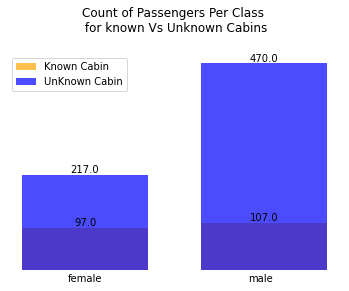

In [545]:
plt.hist(known_cabins_df['Sex'].sort_values(), alpha=0.7, color ='orange',label='Known Cabin', bins=2, rwidth=0.7);
plt.hist(unknown_cabins_df['Sex'].sort_values(), alpha=0.7,color ='blue', label='UnKnown Cabin',bins=2, rwidth=0.7);
plt.legend();
plt.xticks(ticks=[0.25,0.74], labels=['female','male']);

plt_settings(plt, 'Count of Passengers Per Class \n for known Vs Unknown Cabins\n')

## What is the relationship between Fare and Survival?

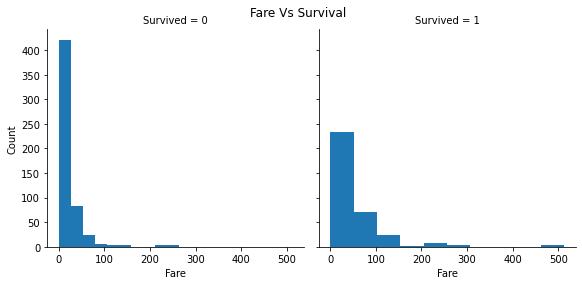

In [26]:
g = sns.FacetGrid(train_data, col ="Survived", height=4,aspect=1) 
g.map(plt.hist, "Fare") 
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Fare Vs Survival\n');
for ax in g.axes.flat:
    ax.set_ylabel('Count')
    break

Text(0.5, 1.0, 'Fare Distribution Per Survival State')

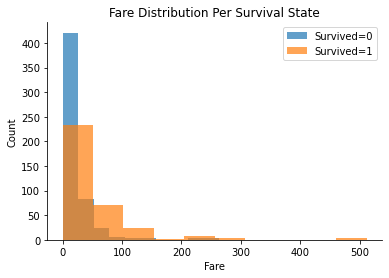

In [559]:
survived_fare = train_data[train_data['Survived']==1]['Fare']
NOsurvived_fare = train_data[train_data['Survived']==0]['Fare']

plt.hist(NOsurvived_fare, label = 'Survived=0', alpha=0.7);
plt.hist(survived_fare, label = 'Survived=1', alpha=0.7);
plt.legend();
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Fare Distribution Per Survival State');

## Name - Title Vs Survival

In [31]:
train_data['passenger_title'] = train_data.Name.apply(lambda x: x.split(',',1)[1].split('.')[0].strip()).values

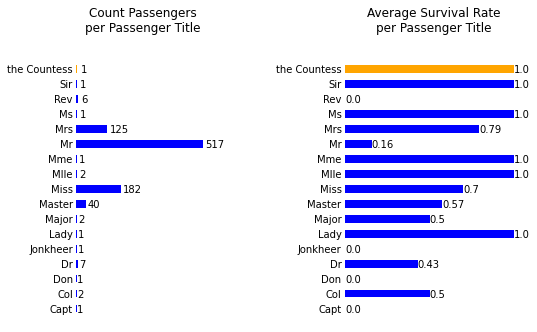

In [33]:
unique_title,title_value_count, avg_survival,colors_map = variable_mean_survival('passenger_title')

plt.figure(figsize=(8,5))
gspec = gridspec.GridSpec(24, 50)
plot1 = plt.subplot(gspec[:, :15])
plot1.barh(unique_title, title_value_count, height = 0.5, color=colors_map)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Count Passengers\nper Passenger Title\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    ax.text( v + rect.get_width(), i-.25 , str(rect.get_width()))
    
plot2 = plt.subplot(gspec[:, 30:]) 
   
plot2.barh(unique_title, avg_survival, height = 0.5, color=colors_map)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Average Survival Rate\nper Passenger Title\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    width = rect.get_width()
    ax.text(rect.get_width() , i-.25 , str(round(width,2)))
   

### Ticket Vs Survival

In [34]:
train_data['Numeric_ticket'] = train_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)

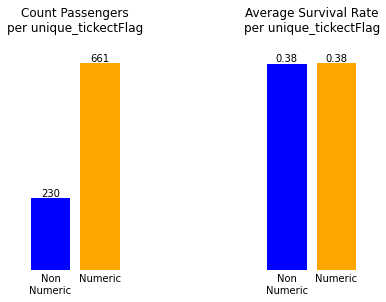

In [35]:
unique_tickectFlag,tickectFlag_value_count, avg_survival,colors_map = variable_mean_survival('Numeric_ticket')

plt.subplot(1,3,1) 
plt.bar(unique_tickectFlag, tickectFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\nper unique_tickectFlag\n')
plt.xticks(ticks=[0,1],labels=['Non\nNumeric','Numeric']);

plt.subplot(1, 3, 3)
plt.bar(unique_tickectFlag,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper unique_tickectFlag\n')
plt.xticks(ticks=[0,1],labels=['Non\nNumeric','Numeric']);

# Dealing with Nulls and Missing values

In [36]:
titanic_train_data = train_data.copy()

### Embaked
has only 2 missing values, so they will be dropped

In [37]:
titanic_train_data.dropna(subset=['Embarked'],inplace = True)

### Age
- replace missing ages by avg age of passengers of the same class
- re-categorize passengers into Age Groups after filling missing values

In [38]:
def get_class_avgAge():
    return titanic_train_data.groupby('Pclass')['Age'].mean()

def derive_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return get_class_avgAge()[Pclass]
    else:
        return Age

titanic_train_data['Age'] = titanic_train_data[['Age','Pclass']].apply(derive_age,axis=1)  
titanic_train_data['Age'] = round(titanic_train_data['Age'], 2)

bins = [0, 2, 12, 17, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'adult', 'elderly']
age_groups = pd.cut(titanic_train_data.Age, bins, labels = labels)
titanic_train_data['Age_Group'] = age_groups
titanic_train_data['Age_Group'] = titanic_train_data['Age_Group'].astype(str)

## Fare
replace missing fares wih avg class fare 

In [39]:
def get_class_avgFare():
    return titanic_train_data.groupby('Pclass')['Fare'].mean()
    
def derive_Fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    if pd.isnull(Fare):
        return get_class_avgFare()[Pclass]
    else:
        return Fare   
    
titanic_train_data['Fare'] = titanic_train_data[['Fare','Pclass']].apply(derive_Fare,axis=1)    

## Data types handling
turn categorical data and Flags into str instead of int

In [40]:
titanic_train_data.Pclass = titanic_train_data.Pclass.astype(str)
titanic_train_data.Numeric_ticket = titanic_train_data.Numeric_ticket.astype(str)
titanic_train_data.Cabin_Flag = titanic_train_data.Cabin_Flag.astype(str)
titanic_train_data.Family_flag = titanic_train_data.Family_flag.astype(str)

## Saving Processed Data

In [49]:
processed_data_path  = os.path.join(project_path,'Data\\Processed_Data\\titanic_train_data_processed.csv')

In [50]:
titanic_train_data.to_csv(processed_data_path, index=False)